# Surface variability of fronts in the North Atlantic

In [1]:
import dask
dask.config.set({"logging.distributed": "warning"})

In [2]:
# Setup cluster
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=20)
client = Client(cluster)
client

<Client: 'tcp://10.32.5.89:46725' processes=0 threads=0, memory=0 B>

In [1]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader
from matplotlib import pyplot as plt

%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

In [3]:
cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.Catalog(cat_url)

In [4]:
# Get variables from catalog
## load 
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()

u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()

In [5]:
ds = xr.merge([sst, sss, u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])


In [6]:
coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)

## Make some maps of properties

In [7]:
# Select region 

sel_atl = np.logical_and(np.logical_and(coords.XC>-80, coords.XC<0 ), 
                           np.logical_and(coords.YC>12, coords.YC<50 ))

In [8]:
coords_atl = xr.merge([coords['YC'].where(sel_atl, drop=True), 
                      coords['XC'].where(sel_atl, drop=True)])

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [10]:
# map of the region
#x_east, y_east = [160, 170, 170, 160, 160], [-60, -60, 60, 60, -60]
#x_west, y_west = [-155, -145, -145, -155, -155], [-60, -60, 60, 60, -60]
#x_atl_east, y_atl_east = [-30, -20, -20, -30, -30], [-60, -60, 60, 60, -60]
#x_atl_west, y_atl_west = [-65, -55, -55, -65, -65], [-60, -60, 60, 60, -60]

x_atl, y_atl = [-80, 0, 0, -80, -80], [10, 10, 60, 60, 10]

#x_sogos, y_sogos = [28, 40, 40, 28, 28], [-56, -56, -48, -48, -48]

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

ax.fill(x_atl, y_atl, color='red', transform=ccrs.PlateCarree(), alpha=0.6)


ax.coastlines()
ax.set_boundary
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True);

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [12]:
SST_sel = ds.SST.where(sel_atl, drop=True)
SSS_sel = ds.SSS.where(sel_atl, drop=True)

In [13]:
from fastjmd95 import rho
ds['SSD'] = xr.apply_ufunc(rho, 
                        ds.SSS, ds.SST, 0, 
                        dask='parallelized', output_dtypes=[float,]).rename('SSD')

In [15]:
SSD_sel = ds.SSD.where(sel_atl, drop=True)

In [10]:
import xgcm
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=None)

In [17]:
U_sel = (grid.interp(ds.U, 'X', boundary='extend')).where(sel_atl, drop=True).rename('U')
V_sel = (grid.interp(ds.V, 'Y', boundary='extend')).where(sel_atl, drop=True).rename('V')

In [18]:
U_sel

<xarray.DataArray 'U' (time: 9030, j: 2378, i: 3840)>
dask.array<where, shape=(9030, 2378, 3840), dtype=float32, chunksize=(1, 2285, 2015), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * j        (j) int64 8547 8548 8549 8550 8551 ... 10921 10922 10923 10924
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279

In [20]:
XC_sel = coords.XC.where(sel_atl, drop=True)
YC_sel = coords.YC.where(sel_atl, drop=True)

In [26]:
sel_atl_z = np.logical_and(np.logical_and(coords.XG>-80, coords.XG<0 ), 
                           np.logical_and(coords.YG>12, coords.YG<50 ))

In [27]:
sel_atl_s = np.logical_and(np.logical_and(coords.XC>-80, coords.XC<0 ), 
                           np.logical_and(coords.YG>12, coords.YG<50 ))
sel_atl_w = np.logical_and(np.logical_and(coords.XG>-80, coords.XG<0 ), 
                           np.logical_and(coords.YC>12, coords.YC<50 ))

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:3864: PerformanceWarning: Increasing number of chunks by factor of 12
  **blockwise_kwargs
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:3864: PerformanceWarning: Increasing number of chunks by factor of 12
  **blockwise_kwargs


In [32]:
sel_atl_s = 

<xarray.DataArray (j_g: 12960, i_g: 17280)>
dask.array<logical_and, shape=(12960, 17280), dtype=bool, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959

In [28]:
XG_sel = coords.XG.where(sel_atl_z, drop=True)
YG_sel = coords.YG.where(sel_atl_z, drop=True)

In [33]:
rAz_sel = coords.rAz.where(sel_atl_z, drop=True)

In [45]:
coords

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * k_p1     (k_p1) int64 0 1
Data variables:
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4017
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Z        float32 -1.57
    Zl       float32 -1.0
    Zp1      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    Zu       float32 -2.14
    drC      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      float32 1.14
    hFacC    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>

In [11]:
zeta =   (-grid.diff(ds.U * coords.dxC, 'Y', boundary='extend') +
             grid.diff(ds.V * coords.dyC, 'X', boundary='extend')
         )/coords.rAz

zeta = grid.interp(grid.interp(zeta, 'X', boundary='extend'),
                   'Y', boundary='extend')

In [12]:
ocean_mask = coords.hFacC.reset_coords(drop=True)>0

In [14]:
zeta_sel = (zeta.where(ocean_mask)).where(sel_atl, drop=True).rename('vort')

In [15]:
zeta_sel

<xarray.DataArray 'vort' (time: 9030, j: 2378, i: 3840)>
dask.array<where, shape=(9030, 2378, 3840), dtype=float32, chunksize=(1, 2284, 2015), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * j        (j) int64 8547 8548 8549 8550 8551 ... 10921 10922 10923 10924
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279

In [22]:
Xmean = coords_atl.XC.isel(i=slice(0,None,10), j=slice(0, None, 10)).mean('j')
Ymean = coords_atl.YC.isel(i=slice(0,None,10), j=slice(0, None, 10)).mean('i')

In [17]:
zeta_sel_coarse = zeta_sel.isel(time=0, i=slice(0,None,10), j=slice(0, None, 10))
zeta_sel_coarse.load()

<xarray.DataArray 'vort' (j: 238, i: 384)>
array([[ 1.1895780e-06, -7.1307619e-07, -5.1459028e-06, ...,
         2.1043963e-05,  4.0097570e-05, -6.2607200e-05],
       [ 1.9576198e-06,  5.9541153e-06,  2.1091637e-06, ...,
         1.7027276e-05, -9.3509916e-06, -4.7221179e-06],
       [-5.5951905e-06,  5.0217122e-06,  1.4487992e-07, ...,
         1.0708002e-05,  5.9523383e-05, -8.5145612e-06],
       ...,
       [-2.0444470e-05, -4.9914211e-06, -1.5937036e-05, ...,
        -9.2474960e-07, -1.9016068e-05, -1.5008072e-05],
       [ 2.4223933e-05,  1.1924203e-05,  8.9936539e-06, ...,
         6.5563449e-07,  1.8104736e-06, -4.3353034e-06],
       [-1.0008137e-05,  7.8236972e-06,  9.7221846e-06, ...,
        -3.0214296e-06,  4.9036189e-06, -1.3668849e-05]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-09-13
  * j        (j) int64 8547 8557 8567 8577 8587 ... 10887 10897 10907 10917
  * i        (i) int64 0 10 20 30 40 50 ... 17220 17230 17240 17250 17260 17270

In [26]:
plt.pcolormesh(Xmean, Ymean, zeta_sel_coarse, 
               vmin=-5e-5, vmax=5e-5, cmap='RdBu_r')
plt.xlim([-80, -60])
plt.ylim([30, 40])

(30, 40)

In [17]:
zeta_sel = zeta.where(sel_atl, drop=True).rename('vort')

In [18]:
bx = (grid.interp(grid.diff(ds.SSD, 'X', boundary='extend')/coords.dxC, 
                    'X', boundary='extend'))
by = (grid.interp(grid.diff(ds.SSD, 'Y', boundary='extend')/coords.dyC, 
                    'Y', boundary='extend'))      

In [19]:
Tx = (grid.interp(grid.diff(ds.SST, 'X', boundary='extend')/coords.dxC, 
                    'X', boundary='extend'))
Ty = (grid.interp(grid.diff(ds.SST, 'Y', boundary='extend')/coords.dyC, 
                    'Y', boundary='extend'))      

In [20]:
bx_sel = bx.where(sel_atl, drop=True).rename('bx')
by_sel = by.where(sel_atl, drop=True).rename('by')

In [21]:
Tx_sel = Tx.where(sel_atl, drop=True).rename('Tx')
Ty_sel = Ty.where(sel_atl, drop=True).rename('Ty')

In [22]:
gradB_sel = np.abs(bx_sel) + np.abs(by_sel)

In [23]:
gradT_sel = np.abs(Tx_sel) + np.abs(Ty_sel)

### Things to consider/do
- Time series of buoyancy
- Maps of buoyancy
- Spectra of buoyancy (spatial)
- Time series of "small-scale" variance (choose some cutoff)

### Time series and maps

In [24]:
SSD_sel_10day_coarse = SSD_sel.isel(time=slice(0,24*370,24*10),
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )

In [25]:
coords_atl_coarse = coords_atl.isel(i = slice(0,None, 4), 
                                    j = slice(0,None, 4) )

In [26]:
Xcoarse =coords_atl_coarse.XC.mean('j')
Ycoarse =coords_atl_coarse.YC.mean('i')

In [27]:
Xatl =coords_atl.XC.mean('j')
Yatl =coords_atl.YC.mean('i')

### Maps of large scale quantities in different seasons

In [28]:
SSD_winter = SSD_sel.sel(time="2012-02-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
SSD_winter.load()
SSD_summer = SSD_sel.sel(time="2012-08-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
SSD_summer.load();

In [29]:
SST_winter = SST_sel.sel(time="2012-02-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
SST_winter.load()
SST_summer = SST_sel.sel(time="2012-08-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
SST_summer.load();

In [30]:
U_winter = U_sel.sel(time="2012-02-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
U_winter.load()
V_winter = V_sel.sel(time="2012-02-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
V_winter.load()

U_summer = U_sel.sel(time="2012-08-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
U_summer.load()
V_summer = V_sel.sel(time="2012-08-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
V_summer.load();

In [31]:
KE_summer = 0.5*(np.abs(U_summer) + np.abs(V_summer))
KE_winter = 0.5*(np.abs(U_winter) + np.abs(V_winter))

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contourf(Xatl, Yatl, SSD_summer, vmin=1021, vmax=1027.4,
             levels=np.linspace(1021.,1027.4,21), extend='both')
plt.title('Summer')
plt.xlim([-80, 0])
plt.ylim([10, 55])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()

plt.subplot(122)
plt.contourf(Xatl, Yatl, SSD_winter, vmin=1021, vmax=1027.4,
             levels=np.linspace(1021.,1027.4,21), extend='both')
plt.title('Winter')
plt.xlim([-80, 0])
plt.ylim([10, 55])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()
plt.tight_layout()

plt.savefig('figures/natl_SSD.png')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [34]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contourf(Xcoarse, Ycoarse, SST_summer, vmin=2, vmax=30,
             levels=np.linspace(2.,30,21), extend='both')
plt.title('Summer')
plt.xlim([-80, 0])
plt.ylim([12, 50])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()

plt.subplot(122)
plt.contourf(Xcoarse, Ycoarse, SST_winter, vmin=2, vmax=30,
             levels=np.linspace(2.,30,21), extend='both')
plt.title('Winter')
plt.xlim([-80, 0])
plt.ylim([12, 50])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()

plt.tight_layout()

plt.savefig('figures/natl_SST.png')

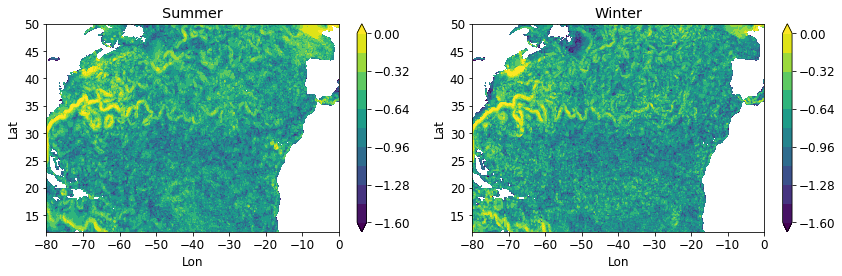

In [36]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contourf(Xcoarse, Ycoarse, np.log10(KE_summer), levels=np.linspace(-1.6,0,11), extend='both')
plt.title('Summer')
plt.xlim([-80, 0])
plt.ylim([12, 50])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()

plt.subplot(122)
plt.contourf(Xcoarse, Ycoarse, np.log10(KE_winter), levels=np.linspace(-1.6,0,11), extend='both')
plt.title('Winter')
plt.xlim([-80, 0])
plt.ylim([12, 50])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()

plt.tight_layout()

plt.savefig('figures/natl_speed.png')

### Maps of gradient quantities

In [37]:
zeta_winter = zeta_sel.sel(time="2012-02-15T00:00:00")
zeta_winter.load()
zeta_summer = zeta_sel.sel(time="2012-08-15T00:00:00")
zeta_summer.load();

In [45]:
f = 2 * 2*np.pi/24/3600 * np.sin(Yatl*np.pi/180)
f.load()

<xarray.DataArray 'YC' (j: 2378)>
array([3.0255494e-05, 3.0302132e-05, 3.0348765e-05, ..., 1.1135549e-04,
       1.1137611e-04, 1.1139673e-04], dtype=float32)
Coordinates:
  * j        (j) int64 8547 8548 8549 8550 8551 ... 10921 10922 10923 10924

In [48]:
plt.pcolormesh(Xatl, Yatl, zeta_winter, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')

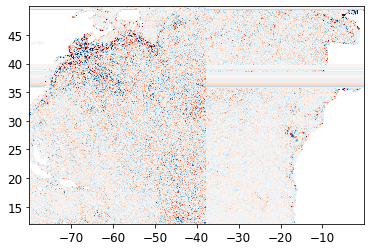

In [50]:
plt.pcolormesh(Xatl, Yatl, zeta_summer, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')

### Spectra Spatial Tracers

In [30]:
import xrft

In [129]:
SSD_sel_10day.time.isel(time=0)

<xarray.DataArray 'time' ()>
array('2011-09-13T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2011-09-13
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

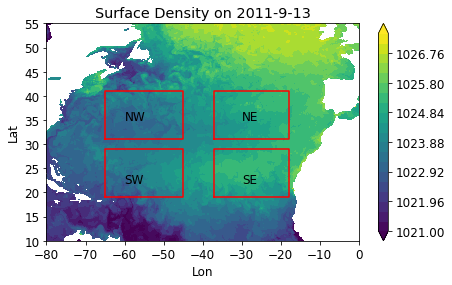

In [154]:
# define 4 regions
xreg1, yreg1 = [-65, -45, -45, -65, -65], [19, 19, 29, 29, 19]
xreg2, yreg2 = [-65, -45, -45, -65, -65], [31, 31, 41, 41, 31]
xreg3, yreg3 = [-37, -18, -18, -37, -37], [19, 19, 29, 29, 19]
xreg4, yreg4 = [-37, -18, -18, -37, -37], [31, 31, 41, 41, 31]

plt.figure(figsize=(7,4))
plt.contourf(Xatl, Yatl, SSD_sel_10day.isel(time=0),
            levels=np.linspace(1021.,1027.4,21), extend='both',
            rasterized=True)
plt.plot(xreg1, yreg1, color='r')
plt.text(-60, 22, 'SW')
plt.plot(xreg2, yreg2, color='r')
plt.text(-60, 35, 'NW')
plt.plot(xreg3, yreg3, color='r')
plt.text(-30, 22, 'SE')
plt.plot(xreg4, yreg4, color='r')
plt.text(-30, 35, 'NE')
plt.xlim([-80, 0])
plt.ylim([10, 55])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()
plt.title('Surface Density on 2011-9-13')
plt.savefig('figures/natl_map.png')

In [17]:
sel_SW = np.logical_and(np.logical_and(coords.XC>-65, coords.XC<-45 ),
                           np.logical_and(coords.YC>19, coords.YC<29))
sel_NW = np.logical_and(np.logical_and(coords.XC>-65, coords.XC<-45 ),
                           np.logical_and(coords.YC>31, coords.YC<41))
sel_SE = np.logical_and(np.logical_and(coords.XC>-37.5, coords.XC<-18.5 ),
                           np.logical_and(coords.YC>19, coords.YC<29))
sel_NE = np.logical_and(np.logical_and(coords.XC>-37.5, coords.XC<-18.5 ),
                           np.logical_and(coords.YC>31, coords.YC<41))

In [19]:
SSD_SE = SSD_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SE, drop=True)
SSD_NE = SSD_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NE, drop=True)
SSD_SW = SSD_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SW, drop=True)
SSD_NW = SSD_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NW, drop=True)

In [21]:
SSS_SE = SSS_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SE, drop=True)
SSS_NE = SSS_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NE, drop=True)
SSS_SW = SSS_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SW, drop=True)
SSS_NW = SSS_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NW, drop=True)

In [22]:
SST_SE = SST_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SE, drop=True)
SST_NE = SST_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NE, drop=True)
SST_SW = SST_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SW, drop=True)
SST_NW = SST_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NW, drop=True)

In [142]:
SST_SE_TS = SST_SE.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SST_SE_TS.load()

SST_SW_TS = SST_SW.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SST_SW_TS.load()

SST_NE_TS = SST_NE.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SST_NE_TS.load()

SST_NW_TS = SST_NW.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SST_NW_TS.load()

<xarray.DataArray 'SST' (time: 25)>
array([26.072424, 25.444542, 23.65991 , 22.915794, 21.561958, 20.641668,
       20.25553 , 19.434353, 18.949808, 18.472025, 18.05794 , 17.87031 ,
       17.6656  , 17.79628 , 17.80756 , 18.772196, 18.7915  , 20.423399,
       21.160423, 22.257166, 24.050156, 25.20783 , 26.569225, 27.396927,
       26.3093  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-28 ... 2012-09-07

In [139]:
SSD_SE_TS = SSD_SE.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SSD_SE_TS.load()

SSD_SW_TS = SSD_SW.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SSD_SW_TS.load()

SSD_NE_TS = SSD_NE.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SSD_NE_TS.load()

SSD_NW_TS = SSD_NW.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SSD_NW_TS.load()

<xarray.DataArray 'SSD' (time: 25)>
array([1023.40774162, 1023.59253418, 1024.24798594, 1024.49094756,
       1024.92698149, 1025.19776067, 1025.35254803, 1025.60963658,
       1025.73692228, 1025.88751953, 1026.01146709, 1026.06263041,
       1026.13414082, 1026.10047518, 1026.06604341, 1025.84610746,
       1025.86279199, 1025.40171512, 1025.13467545, 1024.82705802,
       1024.27883165, 1023.85676408, 1023.3946273 , 1023.0618414 ,
       1023.43823241])
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-28 ... 2012-09-07

In [155]:
plt.figure(figsize=(12,4))

plt.subplot(121)
SSD_SE_TS.plot(linestyle='--',label='SE')
SSD_SW_TS.plot(linestyle='--',label='SW')
SSD_NE_TS.plot(label='NE')
SSD_NW_TS.plot(label='NW')


plt.subplot(122)
SST_SE_TS.plot(linestyle='--',label='SE')
SST_SW_TS.plot(linestyle='--',label='SW')
SST_NE_TS.plot(label='NE')
SST_NW_TS.plot(label='NW')
plt.legend()

plt.tight_layout()

plt.savefig('figures/seasonal_time_series.png')

In [23]:
coords_SW = xr.merge([coords.XC.where(sel_SW, drop=True),
                      coords.YC.where(sel_SW, drop=True)])
coords_SE = xr.merge([coords.XC.where(sel_SE, drop=True),
                      coords.YC.where(sel_SE, drop=True)])
coords_NW = xr.merge([coords.XC.where(sel_NW, drop=True),
                      coords.YC.where(sel_NW, drop=True)])
coords_NE = xr.merge([coords.XC.where(sel_NE, drop=True),
                      coords.YC.where(sel_NE, drop=True)])

In [24]:
dxNW = 110*(coords_NW.XC.isel(i=1) - coords_NW.XC.isel(i=0))*np.cos(coords_NW.YC.mean('i')*np.pi/180)
dxNE = 110*(coords_NE.XC.isel(i=1) - coords_NE.XC.isel(i=0))*np.cos(coords_NE.YC.mean('i')*np.pi/180)

dxSW = 110*(coords_SW.XC.isel(i=1) - coords_SW.XC.isel(i=0))*np.cos(coords_SW.YC.mean('i')*np.pi/180)
dxSE = 110*(coords_SE.XC.isel(i=1) - coords_SE.XC.isel(i=0))*np.cos(coords_SE.YC.mean('i')*np.pi/180)

In [25]:
SSD_SE_k_ps = xrft.power_spectrum(SSD_SE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_SE_psd')
SSD_SW_k_ps = xrft.power_spectrum(SSD_SW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_SW_psd')
SSD_NE_k_ps = xrft.power_spectrum(SSD_NE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_NE_psd')
SSD_NW_k_ps = xrft.power_spectrum(SSD_NW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_NW_psd')

In [26]:
SST_SE_k_ps = xrft.power_spectrum(SST_SE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_SE_psd')
SST_SW_k_ps = xrft.power_spectrum(SST_SW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_SW_psd')
SST_NE_k_ps = xrft.power_spectrum(SST_NE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_NE_psd')
SST_NW_k_ps = xrft.power_spectrum(SST_NW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_NW_psd')

In [27]:
SSD_SE_k_ps.load()
SSD_SW_k_ps.load()
SSD_NE_k_ps.load()
SSD_NW_k_ps.load();

In [28]:
SST_SE_k_ps.load()
SST_SW_k_ps.load()
SST_NE_k_ps.load()
SST_NW_k_ps.load();

In [29]:
import warnings
warnings.filterwarnings('ignore')

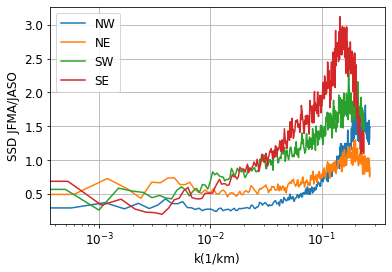

In [32]:
plt.plot(SSD_NW_k_ps.freq_i/dxNE.mean(),
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NW')
plt.plot(SSD_NE_k_ps.freq_i/dxNE.mean(),
         SSD_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SSD_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NE')
plt.plot(SSD_SW_k_ps.freq_i/dxSW.mean(),
         SSD_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SSD_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SW')
plt.plot(SSD_SE_k_ps.freq_i/dxSE.mean(),
         SSD_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SSD_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SE')

plt.xscale('log')
plt.legend()
#plt.ylim([0, 6])
plt.grid()
plt.xlabel('k(1/km)')
plt.ylabel('SSD JFMA/JASO')
plt.savefig('figures/Ratio_SSD.png')

In [33]:
plt.plot(SST_NW_k_ps.freq_i/dxNE.mean(),
         SST_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SST_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NW')
plt.plot(SST_NE_k_ps.freq_i/dxNE.mean(),
         SST_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SST_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NE')
plt.plot(SST_SW_k_ps.freq_i/dxSW.mean(),
         SST_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SST_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SW')
plt.plot(SST_SE_k_ps.freq_i/dxSE.mean(),
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SE')

plt.xscale('log')
plt.legend()
#plt.ylim([0, 6])
plt.grid()
plt.xlabel('k(1/km)')
plt.ylabel('SST JFMA/JASO')
plt.savefig('figures/Ratio_SST.png')

Text(0.5, 1.0, 'North West')

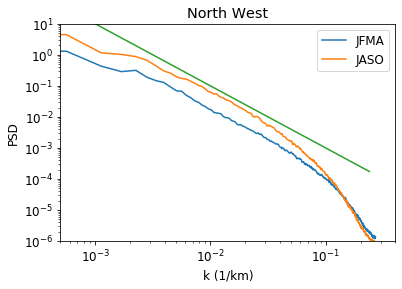

In [45]:
plt.plot(SSD_NW_k_ps.freq_i/dxNE.mean(),
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SSD_NW_k_ps.freq_i/dxNE.mean(),
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-6, 10])
plt.legend()
plt.title('North West')

In [46]:
plt.figure(figsize=(8,7))
plt.subplot(221)
plt.plot(SSD_NW_k_ps.freq_i/dxNE.mean(),
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SSD_NW_k_ps.freq_i/dxNE.mean(),
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SSD_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2, label=r'$k^{-2}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-6, 10])
plt.legend()
plt.title('North West')

plt.subplot(222)
plt.plot(SSD_NE_k_ps.freq_i/dxNE.mean(),
         SSD_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SSD_NE_k_ps.freq_i/dxNE.mean(),
         SSD_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SSD_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-6, 10])
plt.legend()
plt.title('North East')


plt.subplot(223)
plt.plot(SSD_SW_k_ps.freq_i/dxSW.mean(),
         SSD_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SSD_SW_k_ps.freq_i/dxSW.mean(),
         SSD_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SSD_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-6, 10])
plt.legend()
plt.title('South West')

plt.subplot(224)
plt.plot(SSD_SE_k_ps.freq_i/dxSE.mean(),
         SSD_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SSD_SE_k_ps.freq_i/dxSE.mean(),
         SSD_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

k =SSD_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-6, 10])
plt.legend()
plt.title('South East')

plt.tight_layout()

plt.savefig('figures/Spectra_SSD.png')

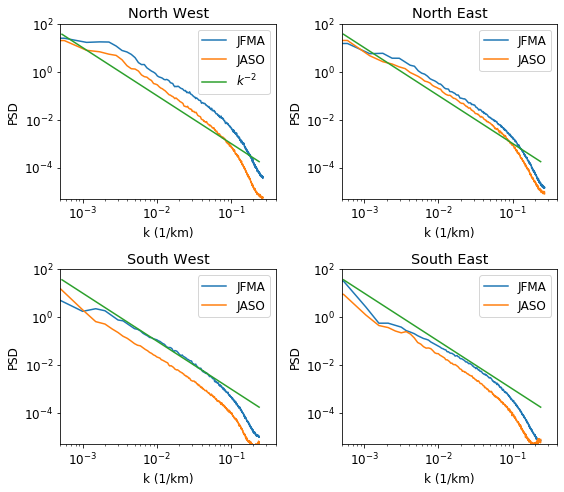

In [44]:
plt.figure(figsize=(8,7))
plt.subplot(221)
plt.plot(SST_NW_k_ps.freq_i/dxNE.mean(),
         SST_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')

plt.plot(SST_NW_k_ps.freq_i/dxNE.mean(),
         SST_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2, label=r'$k^{-2}$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([5e-6, 100])
plt.legend()
plt.title('North West')

plt.subplot(222)
plt.plot(SST_NE_k_ps.freq_i/dxNE.mean(),
         SST_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SST_NE_k_ps.freq_i/dxNE.mean(),
         SST_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([5e-6, 100])
plt.legend()
plt.title('North East')


plt.subplot(223)
plt.plot(SST_SW_k_ps.freq_i/dxSW.mean(),
         SST_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SST_SW_k_ps.freq_i/dxSW.mean(),
         SST_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([5e-6, 100])
plt.legend()
plt.title('South West')

plt.subplot(224)
plt.plot(SST_SE_k_ps.freq_i/dxSE.mean(),
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SST_SE_k_ps.freq_i/dxSE.mean(),
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([5e-6, 100])
plt.legend()
plt.title('South East')

plt.tight_layout()

plt.savefig('figures/Spectra_SST.png')

Text(0.5, 1.0, 'South East')

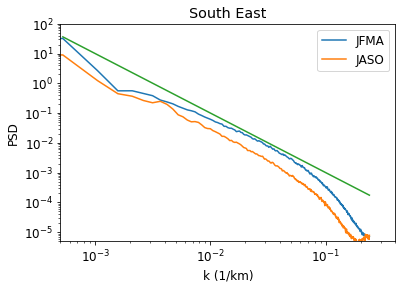

In [42]:
plt.plot(SST_SE_k_ps.freq_i/dxSE.mean(),
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SST_SE_k_ps.freq_i/dxSE.mean(),
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([5e-6, 100])
plt.legend()
plt.title('South East')

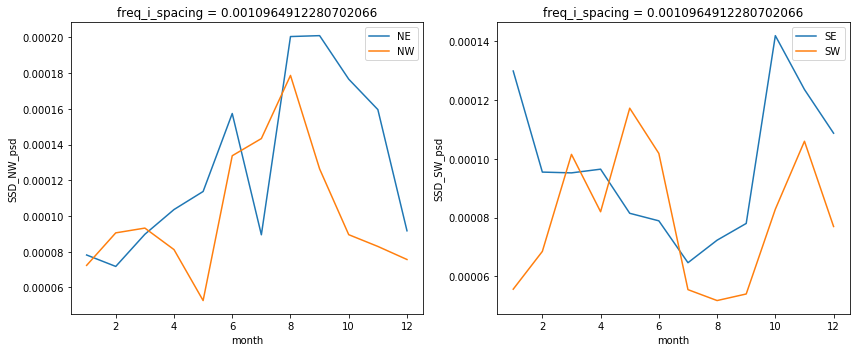

In [106]:
plt.figure(figsize=(12,5))
plt.subplot(121)
SSD_NE_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").mean().plot(label='NE')
SSD_NW_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").mean().plot(label='NW')
plt.legend()

plt.subplot(122)
SSD_SE_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").mean().plot(label='SE')
SSD_SW_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").mean().plot(label='SW')

plt.legend()

plt.tight_layout()

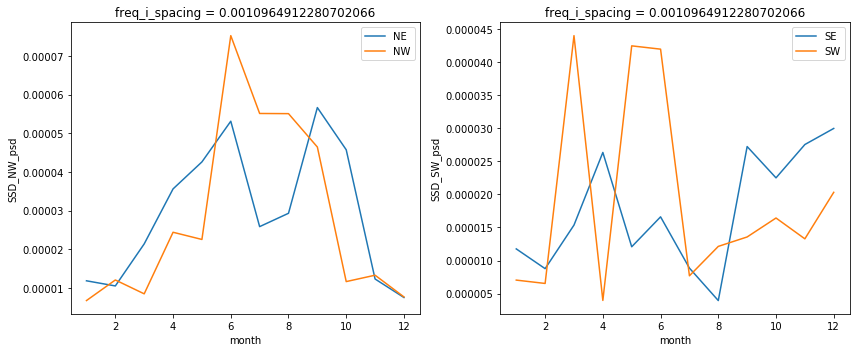

In [107]:
plt.figure(figsize=(12,5))
plt.subplot(121)
SSD_NE_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").std().plot(label='NE')
SSD_NW_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").std().plot(label='NW')
plt.legend()

plt.subplot(122)
SSD_SE_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").std().plot(label='SE')
SSD_SW_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").std().plot(label='SW')

plt.legend()

plt.tight_layout()

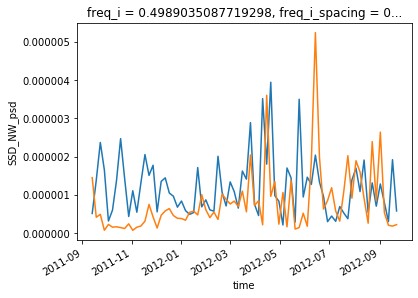

In [108]:
SSD_NE_k_ps.mean('j').isel(freq_i=-1).plot()
SSD_NW_k_ps.mean('j').isel(freq_i=-1).plot()
#SST_SE_k_ps.mean('j').isel(freq_i=-1).plot()
#SST_SW_k_ps.mean('j').isel(freq_i=-1).plot()

### Spectra Spatial Surface Velocity

In [156]:
U_SE = U_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SE, drop=True)
U_NE = U_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NE, drop=True)
U_SW = U_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SW, drop=True)
U_NW = U_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NW, drop=True)

In [157]:
V_SE = V_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SE, drop=True)
V_NE = V_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NE, drop=True)
V_SW = V_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SW, drop=True)
V_NW = V_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NW, drop=True)

In [158]:
U_SE_k_ps = xrft.power_spectrum(U_SE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('U_SE_psd')
U_SW_k_ps = xrft.power_spectrum(U_SW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('U_SW_psd')
U_NE_k_ps = xrft.power_spectrum(U_NE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('U_NE_psd')
U_NW_k_ps = xrft.power_spectrum(U_NW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('U_NW_psd')

In [159]:
V_SE_k_ps = xrft.power_spectrum(V_SE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('V_SE_psd')
V_SW_k_ps = xrft.power_spectrum(V_SW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('V_SW_psd')
V_NE_k_ps = xrft.power_spectrum(V_NE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('V_NE_psd')
V_NW_k_ps = xrft.power_spectrum(V_NW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('V_NW_psd')

In [160]:
EKE_SE_k_ps = V_SE_k_ps + U_SE_k_ps
EKE_SW_k_ps = V_SW_k_ps + U_SW_k_ps
EKE_NE_k_ps = V_NE_k_ps + U_NE_k_ps
EKE_NW_k_ps = V_NW_k_ps + U_NW_k_ps

In [161]:
EKE_SE_k_ps.load()
EKE_SW_k_ps.load()
EKE_NE_k_ps.load()
EKE_NW_k_ps.load()

<xarray.DataArray (time: 37, j: 65, freq_i: 960)>
array([[[3.77418108e-08, 3.57139318e-08, 5.57149643e-08, ...,
         2.13579532e-08, 5.57149643e-08, 3.57139318e-08],
        [2.11710305e-07, 7.28891787e-08, 6.00037530e-08, ...,
         3.82902715e-08, 6.00037530e-08, 7.28891787e-08],
        [3.48908370e-08, 3.97393106e-08, 3.83151517e-08, ...,
         1.82175399e-08, 3.83151517e-08, 3.97393106e-08],
        ...,
        [4.87720789e-08, 3.56555636e-08, 1.62440623e-07, ...,
         2.68898600e-07, 1.62440623e-07, 3.56555636e-08],
        [6.24244557e-08, 1.48492960e-07, 4.58719568e-07, ...,
         7.26411262e-07, 4.58719568e-07, 1.48492960e-07],
        [1.27980430e-07, 2.16434330e-07, 8.54894607e-08, ...,
         9.48596270e-08, 8.54894607e-08, 2.16434330e-07]],

       [[1.53747284e-08, 5.29986262e-08, 6.60565381e-08, ...,
         1.28294614e-07, 6.60565381e-08, 5.29986262e-08],
        [4.43633527e-07, 2.19165584e-07, 3.47296209e-10, ...,
         1.02591716e-07, 3.47296209e-10, 2.19165584e-07],
        [2.07258645e-07, 1.61089495e-07, 1.77920155e-08, ...,
         1.41057511e-07, 1.77920155e-08, 1.61089495e-07],
        ...,
        [3.02113507e-07, 1.92430756e-07, 2.99174814e-07, ...,
         4.92914681e-07, 2.99174814e-07, 1.92430756e-07],
        [1.72210044e-07, 4.15759940e-07, 1.16928034e-06, ...,
         4.49759569e-07, 1.16928034e-06, 4.15759940e-07],
        [6.65770231e-08, 1.17027372e-07, 4.62396101e-08, ...,
         1.56556790e-06, 4.62396101e-08, 1.17027372e-07]],

       [[1.34588686e-07, 3.28569661e-08, 5.01087550e-09, ...,
         1.12348206e-07, 5.01087550e-09, 3.28569661e-08],
        [5.59068576e-07, 8.85770314e-08, 4.11840282e-08, ...,
         9.11020342e-08, 4.11840282e-08, 8.85770314e-08],
        [1.49857140e-08, 9.35182407e-08, 1.02313000e-07, ...,
         2.45323055e-09, 1.02313000e-07, 9.35182407e-08],
        ...,
        [4.77957476e-08, 8.34878535e-08, 3.31156155e-09, ...,
         7.84959488e-08, 3.31156155e-09, 8.34878535e-08],
        [3.47205954e-07, 9.67178601e-08, 2.00208886e-07, ...,
         4.18770763e-07, 2.00208886e-07, 9.67178601e-08],
        [5.17250460e-09, 1.24673405e-08, 4.24922147e-08, ...,
         4.42508716e-07, 4.24922147e-08, 1.24673405e-08]],

       ...,

       [[3.06934193e-08, 4.32194300e-08, 3.96186656e-07, ...,
         2.21773492e-07, 3.96186656e-07, 4.32194300e-08],
        [1.69040095e-08, 3.50605785e-08, 1.44294570e-07, ...,
         2.66571673e-08, 1.44294570e-07, 3.50605785e-08],
        [9.16056841e-08, 2.29724258e-07, 8.81549066e-08, ...,
         1.81658971e-07, 8.81549066e-08, 2.29724258e-07],
        ...,
        [2.47547311e-07, 4.01414489e-07, 3.62643369e-07, ...,
         4.84200962e-07, 3.62643369e-07, 4.01414489e-07],
        [1.10648345e-07, 3.81212203e-07, 4.25018038e-08, ...,
         5.92543806e-07, 4.25018038e-08, 3.81212203e-07],
        [2.98163304e-07, 2.33128103e-07, 4.75517777e-08, ...,
         1.00656468e-07, 4.75517777e-08, 2.33128103e-07]],

       [[9.41144637e-09, 2.97386332e-08, 2.79240221e-08, ...,
         3.37697078e-08, 2.79240221e-08, 2.97386332e-08],
        [2.36215614e-08, 2.05955653e-08, 2.59534485e-07, ...,
         2.56075453e-07, 2.59534485e-07, 2.05955653e-08],
        [9.77722203e-08, 6.26362057e-08, 1.78837894e-07, ...,
         1.44819195e-07, 1.78837894e-07, 6.26362057e-08],
        ...,
        [4.73867608e-08, 1.41073660e-07, 5.17765292e-08, ...,
         1.44532918e-07, 5.17765292e-08, 1.41073660e-07],
        [2.21239342e-07, 4.26668796e-08, 5.05987821e-08, ...,
         9.08492956e-09, 5.05987821e-08, 4.26668796e-08],
        [3.45740542e-08, 9.02108865e-08, 2.53805306e-07, ...,
         1.37422629e-07, 2.53805306e-07, 9.02108865e-08]],

       [[4.61106777e-07, 3.01306639e-08, 8.78821475e-08, ...,
         3.22955035e-07, 8.78821475e-08, 3.01306639e-08],
        [7.27150752e-09, 1.19966276e-09, 4.02683453e-08, ...,
         1.76787216e-07, 4.02683453e-08, 1.19966276e-09],
        [1.43203144e-0

In [232]:
EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4))

<xarray.DataArray (month: 4, freq_i: 960)>
array([[2.22219063e-06, 2.08640913e-06, 2.09570158e-06, ...,
        2.23317394e-06, 2.09570158e-06, 2.08640913e-06],
       [2.60481567e-06, 2.39171801e-06, 2.56672203e-06, ...,
        2.71742049e-06, 2.56672203e-06, 2.39171801e-06],
       [3.38369371e-06, 3.28331963e-06, 3.32034628e-06, ...,
        3.19872187e-06, 3.32034628e-06, 3.28331963e-06],
       [1.27669807e-06, 1.28914410e-06, 1.40204668e-06, ...,
        1.26597088e-06, 1.40204668e-06, 1.28914410e-06]])
Coordinates:
  * freq_i          (freq_i) float64 -0.5 -0.499 -0.4979 ... 0.4969 0.4979 0.499
    freq_i_spacing  float64 0.001042
  * month           (month) int64 1 2 3 4

Text(0.5, 1.0, 'North West')

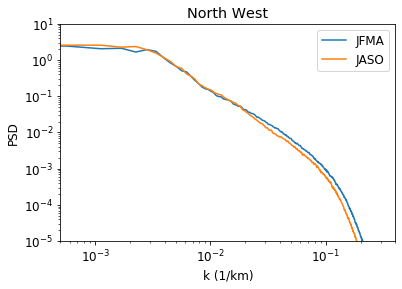

In [233]:
plt.plot(EKE_NW_k_ps.freq_i/dxNE.mean(),
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(EKE_NW_k_ps.freq_i/dxNE.mean(),
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-5, 10])
plt.legend()
plt.title('North West')

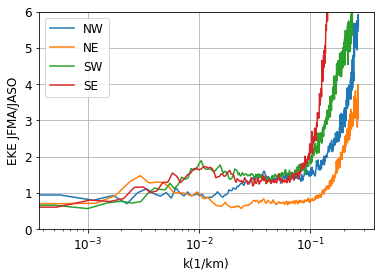

In [247]:
plt.plot(EKE_NW_k_ps.freq_i/dxNE.mean(),
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NW')
plt.plot(EKE_NE_k_ps.freq_i/dxNE.mean(),
         EKE_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         EKE_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NE')
plt.plot(EKE_SW_k_ps.freq_i/dxSW.mean(),
         EKE_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         EKE_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SW')
plt.plot(EKE_SE_k_ps.freq_i/dxSE.mean(),
         EKE_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         EKE_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SE')

plt.xscale('log')
plt.legend()
plt.ylim([0, 6])
plt.grid()
plt.xlabel('k(1/km)')
plt.ylabel('EKE JFMA/JASO')
plt.savefig('figures/Ratio_EKE.png')

In [238]:
plt.figure(figsize=(8,7))
plt.subplot(221)
plt.plot(EKE_NW_k_ps.freq_i/dxNE.mean(),
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(EKE_NW_k_ps.freq_i/dxNE.mean(),
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-5, 10])
plt.legend()
plt.title('North West')

plt.subplot(222)
plt.plot(EKE_NE_k_ps.freq_i/dxNE.mean(),
         EKE_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(EKE_NE_k_ps.freq_i/dxNE.mean(),
         EKE_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-5, 10])
plt.legend()
plt.title('North East')


plt.subplot(223)
plt.plot(EKE_SW_k_ps.freq_i/dxSW.mean(),
         EKE_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(EKE_SW_k_ps.freq_i/dxSW.mean(),
         EKE_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-5, 10])
plt.legend()
plt.title('South West')

plt.subplot(224)
plt.plot(EKE_SE_k_ps.freq_i/dxSE.mean(),
         EKE_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(EKE_SE_k_ps.freq_i/dxSE.mean(),
         EKE_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-5, 10])
plt.legend()
plt.title('South East')

plt.tight_layout()

plt.savefig('figures/Spectra_KE.png')

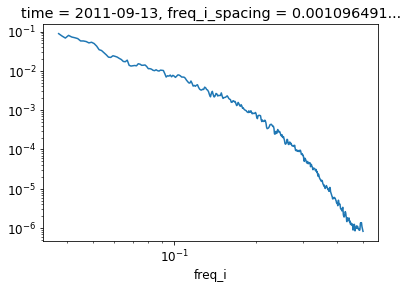

In [177]:
EKE_NE_k_ps.where(EKE_NE_k_ps.freq_i/dxNE.mean()>1/50,
                  drop=True).mean('j').isel(time=0).plot()
plt.xscale('log')
plt.yscale('log')

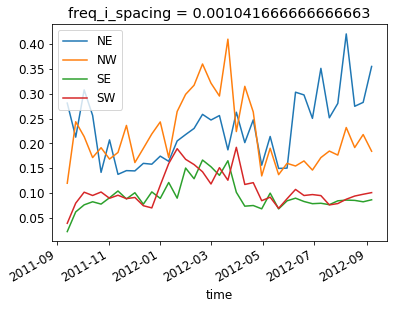

In [181]:
EKE_NE_k_ps.where(EKE_NE_k_ps.freq_i/dxNE.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='NE')
EKE_NW_k_ps.where(EKE_NW_k_ps.freq_i/dxNW.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='NW')
EKE_SE_k_ps.where(EKE_SE_k_ps.freq_i/dxSE.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='SE')
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='SW')
plt.legend()

In [196]:
plt.figure(figsize=(8,6))
plt.subplot(222)
plt.plot(EKE_NE_k_ps.freq_i/dxNE.mean(),
         EKE_NE_k_ps.mean('j').isel(time=0))
plt.plot(EKE_NE_k_ps.freq_i/dxNE.mean(),
         EKE_NE_k_ps.mean('j').isel(time=18))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-7, 10])
plt.title('NE')

plt.subplot(221)
plt.plot(EKE_NW_k_ps.freq_i/dxNW.mean(),
         EKE_NW_k_ps.mean('j').isel(time=0))
plt.plot(EKE_NW_k_ps.freq_i/dxNW.mean(),
         EKE_NW_k_ps.mean('j').isel(time=18))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-7, 10])
plt.title('NW')

plt.subplot(224)
plt.plot(EKE_SE_k_ps.freq_i/dxSE.mean(),
         EKE_SE_k_ps.mean('j').isel(time=0))
plt.plot(EKE_SE_k_ps.freq_i/dxSE.mean(),
         EKE_SE_k_ps.mean('j').isel(time=18))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-7, 10])
plt.title('SE')

plt.subplot(223)
plt.plot(EKE_SW_k_ps.freq_i/dxSW.mean(),
         EKE_SW_k_ps.mean('j').isel(time=0))
plt.plot(EKE_SW_k_ps.freq_i/dxSW.mean(),
         EKE_SW_k_ps.mean('j').isel(time=18))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-7, 10])
plt.title('SW')

plt.tight_layout()

In [228]:
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=slice(0,8)).mean('time').plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=slice(18,26)).mean('time').plot()
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [229]:
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=0).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=1).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=2).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=3).plot()

EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=18).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=19).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=20).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=21).plot()

plt.xscale('log')
plt.yscale('log')
plt.grid()

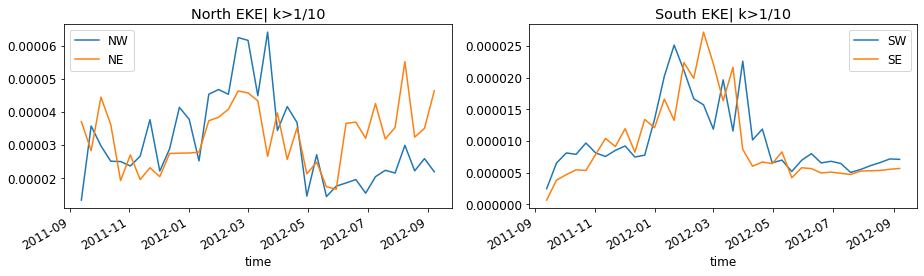

In [227]:
plt.figure(figsize=(13,4))

plt.subplot(121)
(EKE_NW_k_ps.where(EKE_NW_k_ps.freq_i/dxNW.mean()>1/10,
                  drop=True).sum('freq_i').mean('j')*(EKE_NW_k_ps.freq_i_spacing)).plot(label='NW')

(EKE_NE_k_ps.where(EKE_NE_k_ps.freq_i/dxNW.mean()>1/10,
                  drop=True).sum('freq_i').mean('j')*(EKE_NE_k_ps.freq_i_spacing)).plot(label='NE')
plt.legend()
plt.title('North EKE| k>1/10')

plt.subplot(122)
(EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/10,
                  drop=True).sum('freq_i').mean('j')*(EKE_SW_k_ps.freq_i_spacing)).plot(label='SW')

(EKE_SE_k_ps.where(EKE_SE_k_ps.freq_i/dxSW.mean()>1/10,
                  drop=True).sum('freq_i').mean('j')*(EKE_SW_k_ps.freq_i_spacing)).plot(label='SE')
plt.legend()
plt.title('South EKE| k>1/10')

plt.tight_layout()
plt.savefig('figures/small_scale_eke.png')

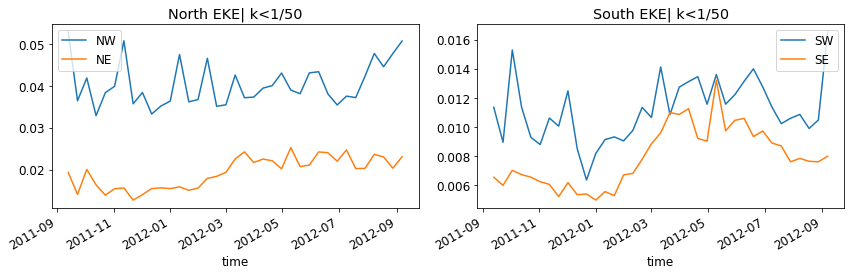

In [226]:
plt.figure(figsize=(12,4))

plt.subplot(121)
(EKE_NW_k_ps.where(EKE_NW_k_ps.freq_i/dxNW.mean()<1/50,
                  drop=True).sum('freq_i').mean('j')*(EKE_NW_k_ps.freq_i_spacing)).plot(label='NW')

(EKE_NE_k_ps.where(EKE_NE_k_ps.freq_i/dxNW.mean()<1/50,
                  drop=True).sum('freq_i').mean('j')*(EKE_NE_k_ps.freq_i_spacing)).plot(label='NE')
plt.legend()
plt.title('North EKE| k<1/50')

plt.subplot(122)
(EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()<1/50,
                  drop=True).sum('freq_i').mean('j')*(EKE_SW_k_ps.freq_i_spacing)).plot(label='SW')

(EKE_SE_k_ps.where(EKE_SE_k_ps.freq_i/dxSW.mean()<1/50,
                  drop=True).sum('freq_i').mean('j')*(EKE_SW_k_ps.freq_i_spacing)).plot(label='SE')
plt.legend()
plt.title('South EKE| k<1/50')

plt.tight_layout()
plt.savefig('figures/large_scale_eke.png')



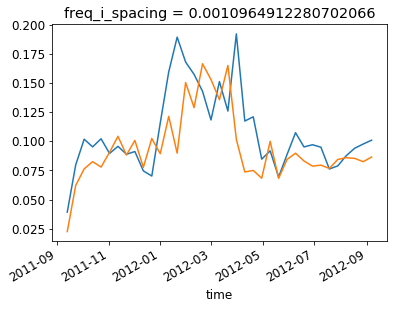

In [199]:
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='SW')

EKE_SE_k_ps.where(EKE_SE_k_ps.freq_i/dxSW.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='SE')

### Time series of variance in different bands

In [ ]:
# Maps of Vorticity
